In [2]:
import jax
import flax
import numpy as np
import jax.numpy as jnp
import tensorflow as tf
import pandas as pd
import os
from flax import linen as nn
from flax.training import train_state 
from flax.training import common_utils
from flax.training import checkpoints
from flax.training import lr_schedule
from flax.training import train_state 
import shutil
import optax
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from glob import glob
import tqdm
from absl import logging
import albumentations as A
from traceback import print_exc
from keras.preprocessing.image import ImageDataGenerator

jax.local_devices()


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

# Data Processing

In [5]:
class DataGenerator:
    def __init__(self,
                data_root: str,
                mode: str,
                class_mode: str,
                rotation_range: int = 20,
                shear_range: float = 0.2,
                zoom_range: list = [0.8, 1.2],
                horizontal_flip: bool = True,
                brightness_range: list = [0.7, 1.3],
                width_shift_range: float = 0.2,
                height_shift_range: float = 0.2,
                batch_size: int = 16,
                img_size: tuple = (224,224),
                shuffle: bool = True,
                color_mode: str = 'rgb'
                ):
       
        self.batch_size = batch_size
        self.img_size = img_size
        self.data_root = data_root
        self.mode = mode
        self.shuffle = shuffle 
        self.class_mode = class_mode
        self.rotation_range = rotation_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.brightness_range = brightness_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.color_mode = color_mode
        
    def get_labels_names(self):
        labels_true = list(set(os.listdir(self.data_root)))
        labels_true.sort()
        labels_true = np.array(labels_true)
        return labels_true
    
    def get_data(self):
        if self.mode=='train':
            train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=self.rotation_range,shear_range=self.shear_range,
                                               zoom_range = self.zoom_range, horizontal_flip=self.horizontal_flip,
                                               brightness_range= self.brightness_range,width_shift_range=self.width_shift_range,
                                               height_shift_range=self.height_shift_range, fill_mode='nearest')
            data = train_datagen.flow_from_directory(directory=self.data_root,
                                                     target_size=self.img_size, batch_size=self.batch_size,
                                                     class_mode=self.class_mode, color_mode=self.color_mode, shuffle=self.shuffle)
        else:
            datagen = ImageDataGenerator(rescale=1./255)
            data = datagen.flow_from_directory(directory=self.data_root,
                                               target_size=self.img_size, batch_size=self.batch_size,
                                               class_mode=self.class_mode, color_mode=self.color_mode, shuffle=self.shuffle)
        return data

In [6]:
batch_size = 64
train_root = '/home/tpnam/trung/cnn/data/dog_cat/train'
train = DataGenerator(data_root=train_root, mode='train', class_mode='binary', batch_size=batch_size)
train_ds = train.get_data()

val_root = '/home/tpnam/trung/cnn/data/dog_cat/test'
val = DataGenerator(data_root=val_root, mode='val', class_mode='binary', batch_size=batch_size)
val_ds = val.get_data()
print('Label: ', train.get_labels_names())

num_classes = int(train_ds.num_classes)

Found 8000 images belonging to 2 classes.

Found 2022 images belonging to 2 classes.

Label:  ['cats' 'dogs']


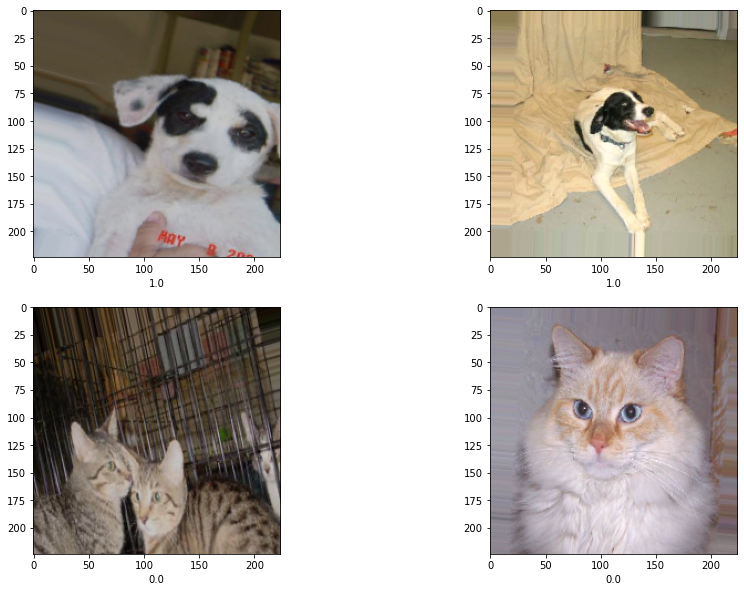

In [7]:
# Show data
img, label = train_ds.next()

fig = plt.figure(figsize=(15,10))
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(img[i])
    plt.xlabel(label[i])
plt.show()

# Build VGG16 Architecture 

In [5]:
class VGG16(nn.Module):
    num_classes: int
    dropout_rate: float = 0.2
    output: str='sigmoid'
    dtype: str='float32'
        
    @nn.compact
    def __call__(self, x, training=False):
        
        if self.output not in ['softmax', 'log_softmax', 'sigmoid', 'linear', 'log_sigmoid']:
            raise ValueError('Wrong argument. Possible choices for output are "softmax", "sigmoid", "log_sigmoid", "linear".')
        
        x = self._Conv_Block(x, features=64, num_layers=2, dtype=self.dtype)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        
        x = self._Conv_Block(x, features=128, num_layers=2, dtype=self.dtype)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        
        x = self._Conv_Block(x, features=256, num_layers=3, dtype=self.dtype)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        
        x = self._Conv_Block(x, features=512, num_layers=3, dtype=self.dtype)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        
        x = self._Conv_Block(x, features=512, num_layers=3, dtype=self.dtype)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        
        # Fully conected
        x = self._GlobalAvgPool2D(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.BatchNorm()(x, use_running_average=not training)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training) 
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.BatchNorm()(x, use_running_average=not training)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training) 
        if self.output == 'softmax':
          x = nn.Dense(features=self.num_classes)(x) 
          x = nn.softmax(x)
        if self.output == 'log_softmax':
          x = nn.Dense(features=self.num_classes)(x) 
          x = nn.log_softmax(x)
        if self.output == 'sigmoid':
          x = nn.Dense(features=1)(x) 
          x = nn.sigmoid(x)
        if self.output == 'log_sigmoid':
          x = nn.Dense(features=1)(x) 
          x = nn.log_sigmoid(x)
        if self.output == 'linear':
          x = nn.Dense(features=1)(x) 
        return x
    
    def _GlobalAvgPool2D(self, inputs):
        x = jnp.mean(inputs, axis=(2, 3))
        return x
    
    def _Conv_Block(self, x, features, num_layers, dtype):
        for l in range(num_layers):
            x = nn.Conv(features=features, kernel_size=(3, 3), padding='same', dtype=dtype)(x)
            x = nn.relu(x)
        return x

In [8]:
model = VGG16(num_classes=num_classes)
print(model.tabulate(jax.random.PRNGKey(0), jnp.ones((batch_size, 224, 224, 3))))


                                 VGG16 Summary                                  
┏━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path       ┃ module    ┃ inputs      ┃ outputs    ┃ params      ┃ batch_sta… ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│            │ VGG16     │ float32[64… │ float32[6… │             │            │
├────────────┼───────────┼─────────────┼────────────┼─────────────┼────────────┤
│ Conv_0     │ Conv      │ float32[64… │ float32[6… │ bias:       │            │
│            │           │             │            │ float32[64] │            │
│            │           │             │            │ kernel:     │            │
│            │           │             │            │ float32[3,… │            │
│            │           │             │            │             │            │
│            │           │             │            │ 1,792 (7.2  │            │
│            │           │ 

# Train Model

In [9]:
# Define loss function for binary class
def binary_cross_entropy_loss(logits,one_hot_encoded_labels):
    return optax.sigmoid_binary_cross_entropy(logits=logits,
                                              labels=one_hot_encoded_labels).mean()

# Define loss function for categorical class
def categorical_cross_entropy_loss(logits, one_hot_encoded_labels):
    return optax.softmax_cross_entropy(logits=logits,
                                       labels=one_hot_encoded_labels).mean()
    
# Define metric for binary class
def binary_metrics(logits, labels, threshold=0.5):
    loss = binary_cross_entropy_loss(logits=logits, one_hot_encoded_labels=labels)
    accuracy = jnp.mean(jnp.where(logits > threshold, 1.0, 0.0) == labels)
    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

# Define metric for categorical class
def categorical_metrics(logits, labels):
    loss = categorical_cross_entropy_loss(logits=logits, one_hot_encoded_labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

In [10]:
# Checkpoints
def save_checkpoint(state, ckpt_dir):
    if os.path.exists(ckpt_dir):
        shutil.rmtree(ckpt_dir) 
    checkpoints.save_checkpoint(ckpt_dir=ckpt_dir, 
                                target=state, 
                                step=state.step, 
                                keep=2)
    
def load_checkpoint(state, ckpt_dir):
  return checkpoints.restore_checkpoint(ckpt_dir, state)

In [11]:
def create_train_state(rng, model, learning_rate):
    # Dummy Input for initializing the model
    dummy_input = jnp.ones(
        shape=(batch_size, 224, 224, 3)
    )
    # Initialize the parameters
    params = model.init(rng, dummy_input)
    model.apply(params, dummy_input)
    # Check the parameters
    jax.tree_map(lambda x: x.shape, params)
    # Create the optimizer
    optimizer = optax.sgd(learning_rate=learning_rate)
    state = train_state.TrainState.create(apply_fn=model.apply, 
                                        tx=optimizer,
                                        params=params)
    return state

In [12]:
# Define the training step with @jax.jit for faster training
@jax.jit
def train_step(state: train_state.TrainState, batch: jnp.ndarray, dropout_rng):
    def loss_fn(state, params, batch):
        image, label = batch
        logits = state.apply_fn(
            params,
            image,
            training=True,
            mutable=["batch_stats"],  # for batch normalization
            rngs={"dropout": dropout_rng},  # for dropout
        )[0]

        # print(logits.shape)
        loss = binary_cross_entropy_loss(logits=logits, one_hot_encoded_labels=label)
        return loss, logits

    # Create Gradient Function by passing in the function
    gradient_fn = jax.value_and_grad(
        loss_fn,  # Function to calculate the loss
        argnums=1,  # Parameters are second argument of the function
        has_aux=True,  # Function has additional outputs, here accuracy
    )
    # Pass in the params from the TrainState
    (loss, logits), grads = gradient_fn(state, state.params, batch)
    # Update Parameters
    state = state.apply_gradients(grads=grads)
    return state, loss

In [13]:
@jax.jit
def eval_step(state, batch, dropout_rng):
    image, label = batch
    logits = state.apply_fn(
        state.params,
        image,
        training=True,
        mutable=["batch_stats"],        # for batch normalization
        rngs={"dropout": dropout_rng},  # for dropout
    )[0]
    return binary_metrics(logits=logits, labels=label)

In [14]:
best_acc = 0.0
ckpt_dir = '/home/tpnam/trung/cnn/src/checkpoints'
seed = 0
learning_rate = 0.001
num_epochs = 1

# PRNG Key
rng = jax.random.PRNGKey(seed)
dropout_rng = jax.random.PRNGKey(seed)

# Instantiate the Model
model = VGG16(num_classes=num_classes)

# Create the train state
state = create_train_state(rng, model, learning_rate)

training_accuracy = []
training_loss = []
val_accyracy = []
val_loss = []
# Start training loop
for epoch in range(1, num_epochs + 1):
    train_ds.on_epoch_end()
    print(f"Epoch {epoch}/{num_epochs}:")
    # Training
    for step in tqdm.trange(1, len(train_ds)+1, desc="\t \033[94mTraining "):
        batch_train = train_ds.next()
        state, loss = train_step(state, batch_train, dropout_rng)
        train_metrics = eval_step(state, batch_train, dropout_rng)
    print(f"\t Loss: {train_metrics['loss']}, accuracy: {train_metrics['accuracy']}")
    training_accuracy.append(train_metrics['accuracy'])
    training_loss.append(train_metrics['loss'])
    
    # Validation
    for step in tqdm.trange(1, len(val_ds)+1, desc="\t \033[94mValidation "):
        batch_val = val_ds.next()
        val_metrics = eval_step(state, batch_val, dropout_rng)
    print(f"\t Loss: {val_metrics['loss']}, accuracy: {val_metrics['accuracy']}")
    val_accyracy.append(val_metrics['accuracy'])
    val_loss.append(val_metrics['loss'])
    
    # Checkpoints based on val_accuracy
    if val_metrics['accuracy'] > best_acc:
        best_acc = val_metrics['accuracy']
        save_checkpoint(state, ckpt_dir)
        


Epoch 1/1:


	 Training : 100%|██████████| 125/125 [02:35<00:00,  1.25s/it]


	 Loss: 0.7444015145301819, accuracy: 0.4990234375


	 Validation : 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


	 Loss: 0.6619105935096741, accuracy: 0.5277008414268494


/tmp/ipykernel_618804/187484127.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.

  plt.grid(b=True, which='major', color='#666666', linestyle='-')


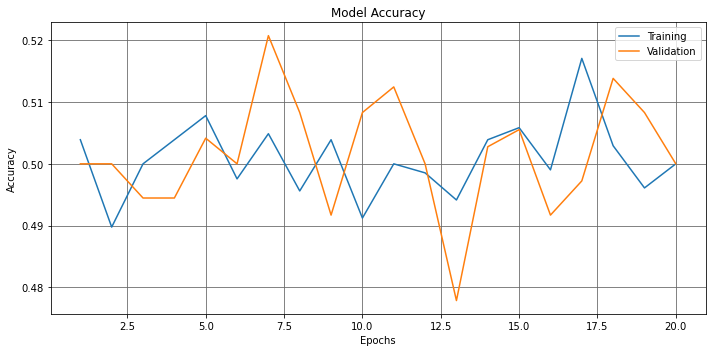

/tmp/ipykernel_618804/187484127.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.

  plt.grid(b=True, which='major', color='#666666', linestyle='-')


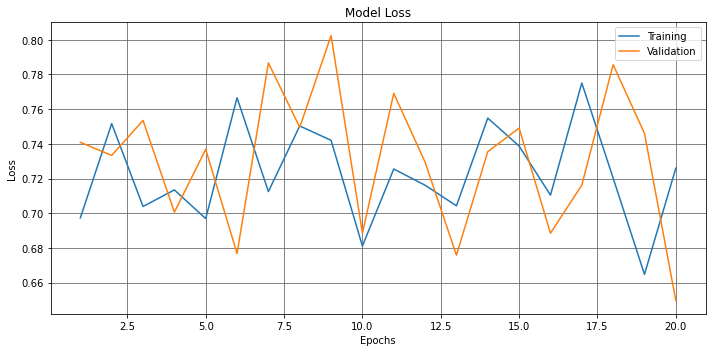

In [7]:
def visualize_metrics(num_epochs, train_accuracy, val_accracy, train_loss, val_loss):
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, train_accuracy, label='Training')
    plt.plot(epochs_range, val_accracy, label='Validation')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, train_loss, label='Training')
    plt.plot(epochs_range, val_loss, label='Validation')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.tight_layout()
    plt.show()

visualize_metrics(num_epochs=num_epochs,
                  train_accuracy=training_accuracy,
                  val_accracy=val_accyracy,
                  train_loss=training_loss,
                  val_loss=val_loss)